{'latitude': [-38.5, -38.25, -38.0, -37.75, -37.5, -37.25, -37.0], 'longitude': [144.25, 144.5, 144.75, 145.0, 145.25, 145.5, 145.75]}
7


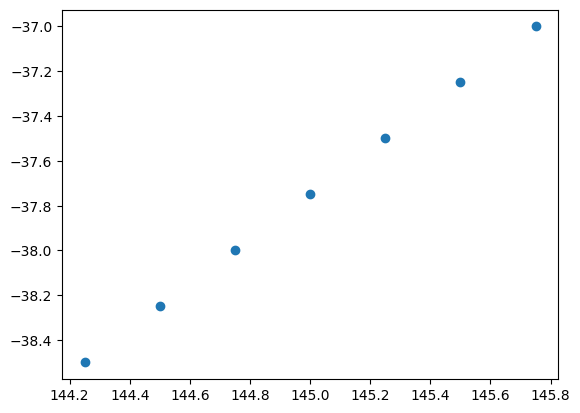

In [5]:
center_latitude = -37.75
center_longitude = 145.0

# Set the range
range_degrees = 0.75

# Set the increment
increment = 0.25

# Generating the list of latitudes and longitudes within 2 degrees of the center point
latitudes = [center_latitude + i * increment for i in range(int(-range_degrees / increment), int(range_degrees / increment) + 1)]
longitudes = [center_longitude + i * increment for i in range(int(-range_degrees / increment), int(range_degrees / increment) + 1)]

# Formatting as JSON
result = {
    "latitude": latitudes,
    "longitude": longitudes
}

print(result)
print(len(result['latitude']))

import matplotlib.pyplot as plt

plt.scatter(result['longitude'], result['latitude'])

In [6]:
# get all possible lat-lon combinations
import itertools
import numpy as np

latlon = np.array(list(itertools.product(result['latitude'], result['longitude'])))
print(latlon.shape)


(49, 2)


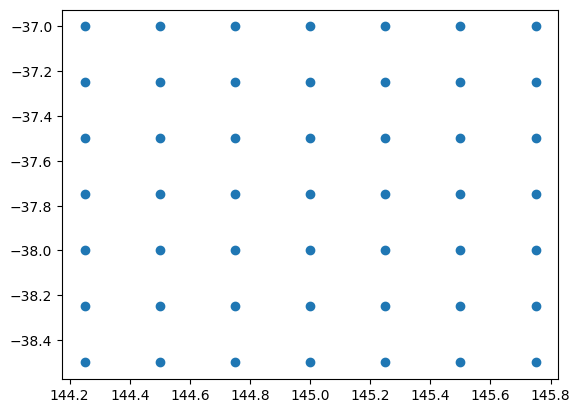

In [7]:
lat = latlon[:,0]
lon = latlon[:,1]
plt.scatter(lon, lat)

In [8]:
lat

array([-38.5 , -38.5 , -38.5 , -38.5 , -38.5 , -38.5 , -38.5 , -38.25,
       -38.25, -38.25, -38.25, -38.25, -38.25, -38.25, -38.  , -38.  ,
       -38.  , -38.  , -38.  , -38.  , -38.  , -37.75, -37.75, -37.75,
       -37.75, -37.75, -37.75, -37.75, -37.5 , -37.5 , -37.5 , -37.5 ,
       -37.5 , -37.5 , -37.5 , -37.25, -37.25, -37.25, -37.25, -37.25,
       -37.25, -37.25, -37.  , -37.  , -37.  , -37.  , -37.  , -37.  ,
       -37.  ])

In [9]:
lon

array([144.25, 144.5 , 144.75, 145.  , 145.25, 145.5 , 145.75, 144.25,
       144.5 , 144.75, 145.  , 145.25, 145.5 , 145.75, 144.25, 144.5 ,
       144.75, 145.  , 145.25, 145.5 , 145.75, 144.25, 144.5 , 144.75,
       145.  , 145.25, 145.5 , 145.75, 144.25, 144.5 , 144.75, 145.  ,
       145.25, 145.5 , 145.75, 144.25, 144.5 , 144.75, 145.  , 145.25,
       145.5 , 145.75, 144.25, 144.5 , 144.75, 145.  , 145.25, 145.5 ,
       145.75])